## **Code Reference Adress:** [MaximeVandegar:Papers-in-100-Lines-of-Code](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Variational_Inference_with_Normalizing_Flows/Flows.py#L29)

## Import necessary packages

In [145]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math

## Introduce random seeds to reproduce result

In [146]:
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available else 'cpu'

### Probability density of Standard Gaussian Distribution:
### $$ p(z) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{z^2}{2}) $$
### Logarithm probability density function of Gaussian Distribution:
### $$ \log{p(z)} = -\frac{1}{2}(\log(2\pi)+z^2) $$

In [147]:
def gaussian_log_pdf(z):
    """
    Arguments:
    ----------
        - z: a batch of m data points (size: m x data_dim)
    """
    return -.5 * (torch.log(torch.tensor([math.pi * 2], device=z.device)) + z ** 2).sum(1)

### Define PlanarFlow:
### $$ f(\mathbf{z}) = \mathbf{z} + \mathbf{u} h(\mathbf{w}^T \mathbf{z} + b),\ \ \lambda = \{\mathbf{w} \in\mathbb{R}^D,\mathbf{u}\in\mathbf{R}^D,b\in\mathbb{R}\} $$
### Compute the logdet-Jacobian(using the matrix lemmma):
### $$ \psi(\mathbf{z})= h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w} $$
### $$ \left| \det \frac{\partial f}{\partial \mathbf{z}} \right| = \left| \det(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^T)\right| = \left| 1+ \mathbf{u}^T\psi(\mathbf{z}) \right| $$

### $$ h(\mathbf{z})=\tanh(\mathbf{z}) $$

### $$ h'(\mathbf{z}) = 1-(\tanh(\mathbf{z}))^2  $$

### Target: Train the trainable parameters:  $ \mathbf{u}, \mathbf{w}, \mathbf{b} $

In [148]:
class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z: (1 - self.h(z) ** 2)

    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))

    def forward(self, z):
        u = self.constrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b
        x = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = torch.log((1 + torch.matmul(u.T, psi)).abs() + 1e-15)
        return x, log_det

### Define flow
### $$ \mathbf{z}_K = f_K \circ f_{K-1} \circ \cdots \circ f_1(\mathbf{z}) $$
### And Calculate log_det

In [149]:
class NormalizingFlow(nn.Module):

    def __init__(self, flow_length, data_dim):
        super().__init__()

        self.layers = nn.Sequential(
            *(PlanarFlow(data_dim) for _ in range(flow_length)))

    def forward(self, z):
        log_jacobians = 0
        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians


### Calculate the logarithm probability density of $ \mathbf{z_K} $
### $$ \log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}) - \sum\limits{k=1}^K \log \left| 1+ \mathbf{u}_k ^T \psi_k(\mathbf{z}_{k-1}) \right| $$

In [150]:
def train(flow, optimizer, nb_epochs, log_density, batch_size, data_dim):
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        # Generate new samples from the flow
        z0 = torch.randn(batch_size, data_dim).to(device)
        zk, log_jacobian = flow(z0)

        # Evaluate the exact and approximated densities
        flow_log_density = gaussian_log_pdf(z0) - log_jacobian
        exact_log_density = log_density(zk).to(device)

        # Compute the loss
        reverse_kl_divergence = (flow_log_density - exact_log_density).mean()
        optimizer.zero_grad()
        loss = reverse_kl_divergence
        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())
    return training_loss

### Plot

In [151]:
def plot_flow_density(flow, ax, lims=np.array([[-4, 4], [-4, 4]]), cmap="coolwarm", title=None,
                      nb_point_per_dimension=1000):
    # Sample broadly from the latent space
    latent_space_boundaries = np.array([[-15, 15], [-15, 15]]);
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1], nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1), dtype=torch.float)
    # Generate data points and evaluate their densities
    zk, log_jacobian = flow(z.to(device))
    final_log_prob = gaussian_log_pdf(z) - log_jacobian.cpu()
    qk = torch.exp(final_log_prob)

    ax.set_xlim(lims[0][0], lims[0][1]); ax.set_ylim(lims[1][0], lims[1][1])
    ax.pcolormesh(
        zk[:, 0].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension),
        zk[:, 1].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension) * -1,
        qk.detach().data.reshape(nb_point_per_dimension, nb_point_per_dimension),
        cmap=cmap,
        rasterized=True,
    )
    if title is not None:
        plt.title(title, fontsize=22)

In [152]:
def plot_exact_density(ax, exact_log_density, lims=np.array([[-4, 4], [-4, 4]]), nb_point_per_dimension=100,
                       cmap="coolwarm", title=None):
    xx, yy = np.meshgrid(np.linspace(lims[0][0], lims[0][1], nb_point_per_dimension),
                         np.linspace(lims[1][0], lims[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1))
    density = torch.exp(exact_log_density(z)).reshape(nb_point_per_dimension, nb_point_per_dimension)
    ax.imshow(density, extent=([lims[0][0], lims[0][1], lims[1][0], lims[1][1]]), cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=22)

### **Potential** $ U(\mathbf{z}) $

In [153]:
w1 = lambda z: torch.sin((2 * np.pi * z[:, 0]) / 4)
w2 = lambda z: 3 * torch.exp(-(((z[:, 0] - 1) / 0.6) ** 2) / 2)
w3 = lambda z: 3 * 1 / (1 + torch.exp(- ((z[:, 0] - 1) / 0.3)))
# Energy functions
U1 = lambda z: (((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2)))
U2 = lambda z: (((z[:, 1] - w1(z)) / 0.4) ** 2) / 2
U3 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.35) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2) / 2))
U4 = lambda z: - torch.log(1e-15 + torch.exp(-(((z[:, 1] - w1(z)) / 0.4) ** 2) / 2) + torch.exp(
    -(((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2) / 2))

### **Main**

  0%|          | 16/20000 [00:00<02:07, 156.97it/s]

100%|██████████| 20000/20000 [02:02<00:00, 163.06it/s]
/tmp/ipykernel_581709/3831089048.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(
100%|██████████| 20000/20000 [06:02<00:00, 55.24it/s]
/tmp/ipykernel_581709/3831089048.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(
100%|██████████| 20000/20000 [17:22<00:00, 19.18it/s]
/tmp/ipykernel_581709/3831089048.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edge

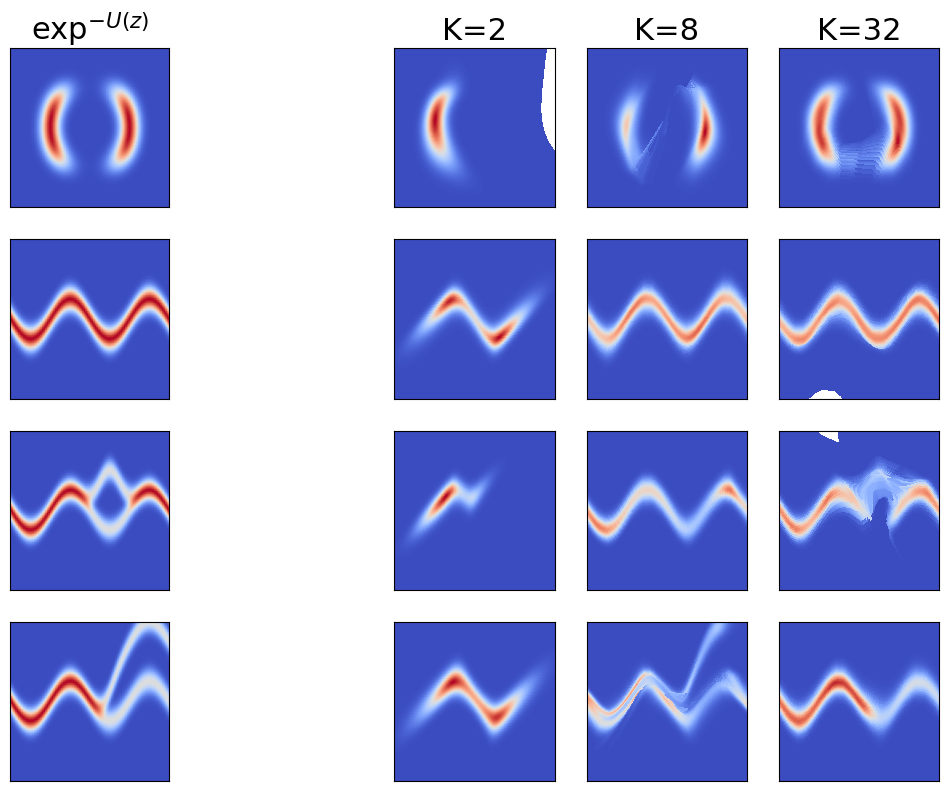

In [154]:
if __name__ == "__main__":
    device = 'cuda'; data_dim = 2; index = 1

    plt.figure(figsize=(12, 12))
    for U in [U1, U2, U3, U4]:
        exact_log_density = lambda z: - U(z)

        # Plot the exact density
        ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
        plot_exact_density(ax, exact_log_density, title=r'$\exp^{-U(z)}$' if index == 1 else None)
        index += 2

        for flow_length in [2, 8, 32]:
            flow = NormalizingFlow(flow_length, data_dim).to(device)
            optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
            loss = train(flow, optimizer, 20000, exact_log_density, 4096, data_dim)

            # Plot the learned density
            ax = plt.subplot(5, 5, index); plt.xticks([], []); plt.yticks([], [])
            plot_flow_density(flow, ax, title=f'K={flow_length}' if index <= 5 else None)
            index += 1
    plt.savefig('learned_densities.png')
    plt.show()